In [13]:
import torch
import torch.nn as nn 
import torch.nn.functional as F 
from torch.utils.data import DataLoader
from torchvision import datasets, transforms as T 
from torchvision.utils import make_grid

import os
from PIL import Image 
from IPython.display import display

import warnings 
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

In [23]:
path = r'C:\Users\wojew\OneDrive\Pulpit\VS_Code\AI\Kaggle\chest_xray\Windows'

In [24]:
# Checking how many images there are and getting their names 
img_names = []

for folder, subfolders, filenames in os.walk(path):
    for img in filenames:
        img_names.append(folder +'/'+ img)

In [25]:
len(img_names)

5856

In [26]:
img_sizes = []
rejected = []

for item in img_names:
    try:
        with Image.open(item) as img:
            img_sizes.append(img.size)
    except:
        rejected.append(item)

In [27]:
print(len(img_sizes))
print(len(rejected))

5856
0


In [28]:
df = pd.DataFrame(img_sizes)

In [29]:
df.head()

,0,1
0,1857,1317
1,2111,1509
2,2031,1837
3,1663,1326
4,2053,1818


In [30]:
df[0].describe()

count    5856.000000
mean     1327.880806
std       363.500922
min       384.000000
25%      1056.000000
50%      1281.000000
75%      1560.000000
max      2916.000000
Name: 0, dtype: float64

In [31]:
df[1].describe()

count    5856.000000
mean      970.689037
std       383.392117
min       127.000000
25%       688.000000
50%       888.000000
75%      1187.000000
max      2713.000000
Name: 1, dtype: float64

In [32]:
torch.cuda.is_available()

True

In [33]:
torch.cuda.get_device_name(0)

'GeForce GTX 1060 6GB'

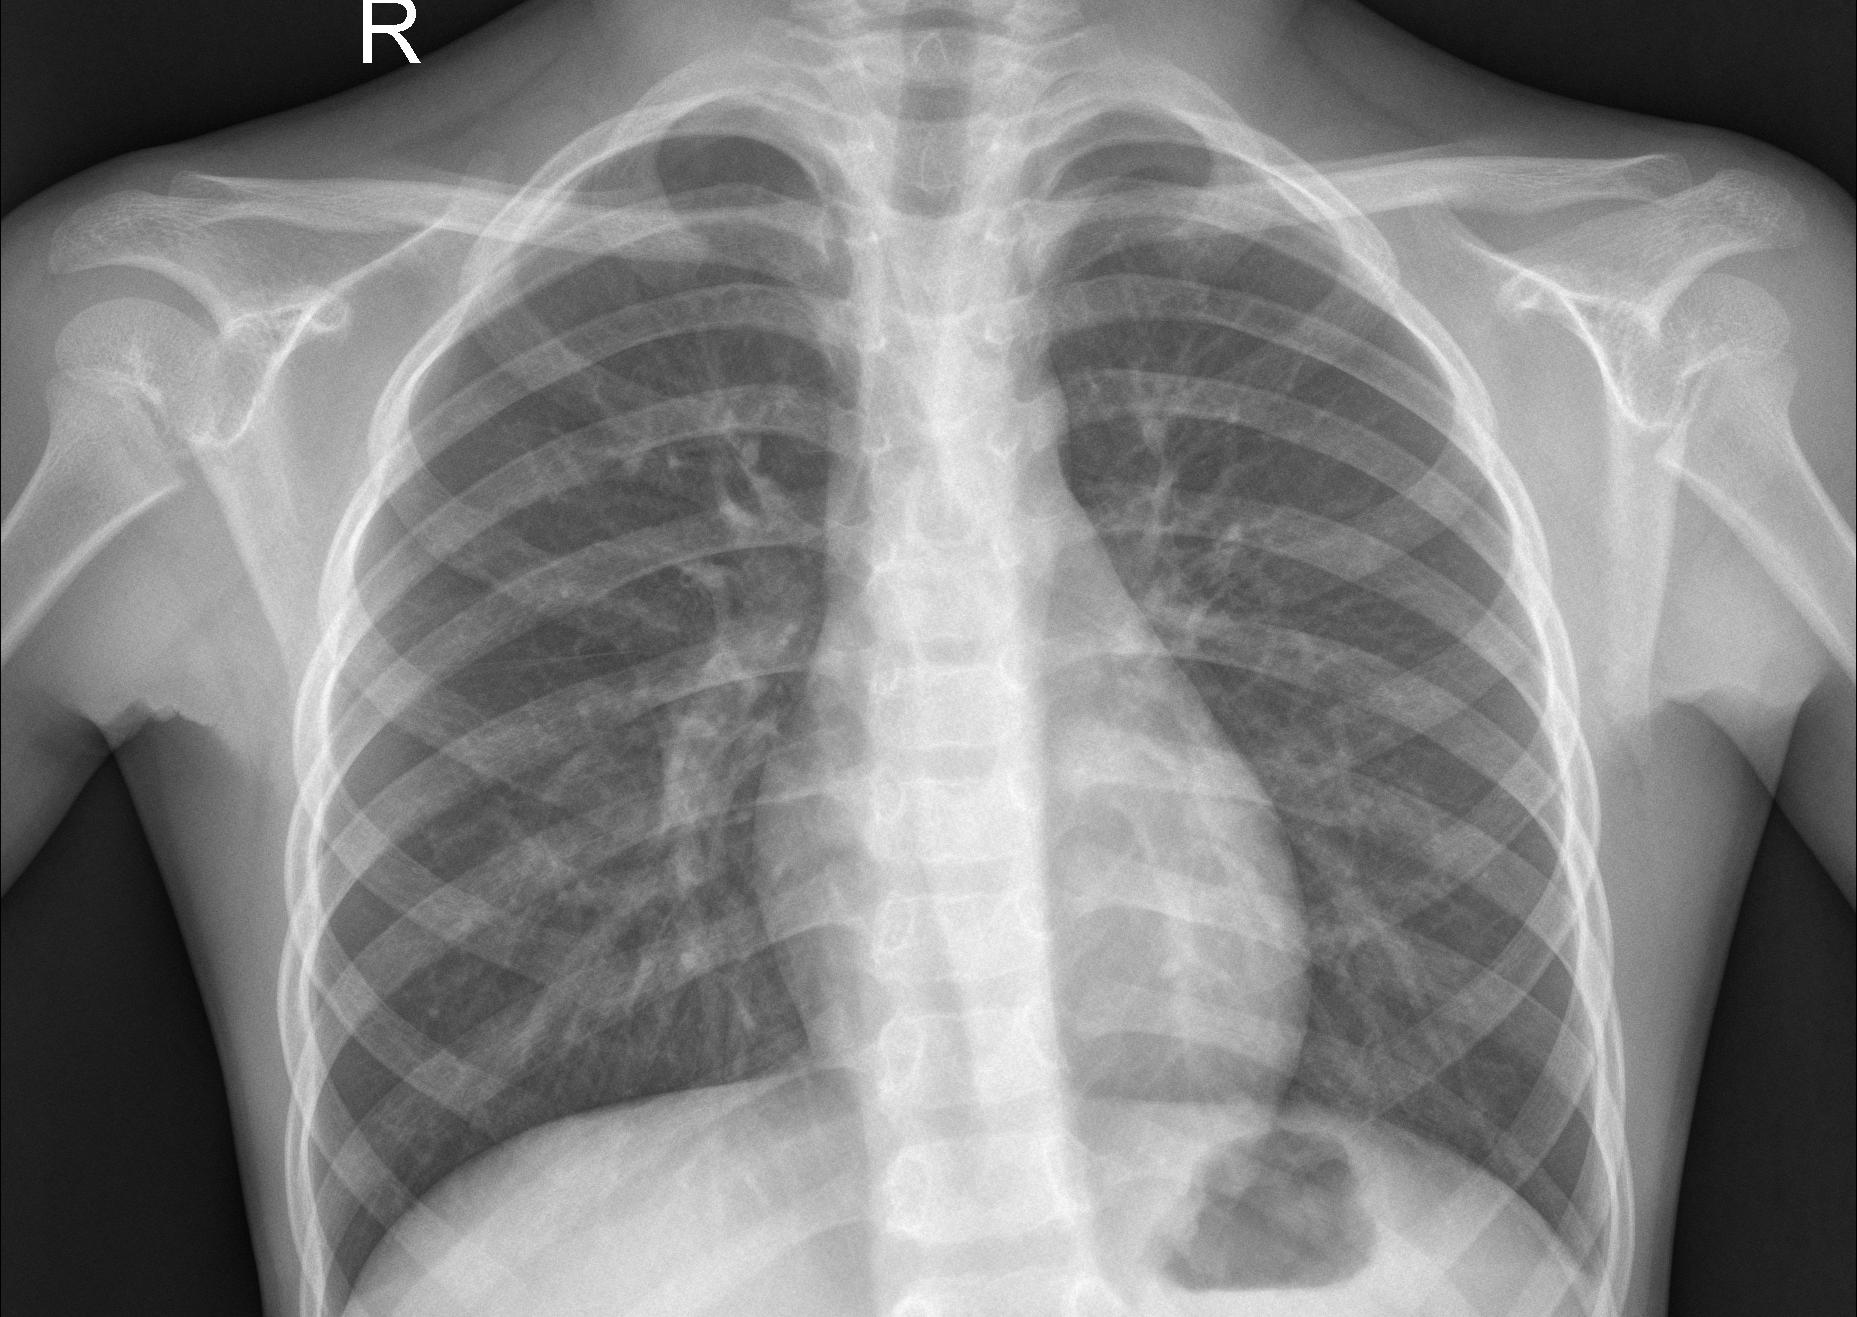

In [34]:
chest = Image.open(path+'/test/NORMAL/IM-0001-0001.jpeg')
display(chest)

In [35]:
transform = T.Compose([
    T.Resize((1000,1000)),
    T.CenterCrop(1000),
    T.ToTensor()
])

In [36]:
chest1 = transform(chest)

In [37]:
print(type(chest1))

<class 'torch.Tensor'>


In [38]:
print(chest1.shape)

torch.Size([1, 1000, 1000])


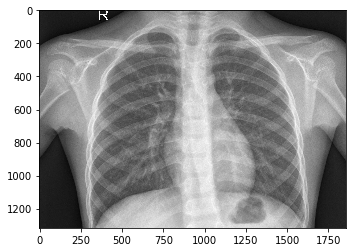

In [39]:
plt.imshow(chest)

In [40]:
train_transform = T.Compose([
    T.Resize((1000, 1000)),
    T.CenterCrop(1000),
    T.RandomHorizontalFlip(p=0.4),
    T.RandomRotation(10),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [41]:
test_transform = T.Compose([
    T.Resize((1000, 1000)),
    T.CenterCrop(1000),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [44]:
root = r'C:\Users\wojew\OneDrive\Pulpit\VS_Code\AI\Kaggle\chest_xray\Windows/'

train_data = datasets.ImageFolder(os.path.join(root, 'train'), transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(root, 'test'), transform=test_transform)

In [46]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False, num_workers=0, pin_memory=True)

In [47]:
class_names = train_data.classes

In [48]:
class_names

['NORMAL', 'PNEUMONIA']

In [49]:
for images, labels in train_loader:
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


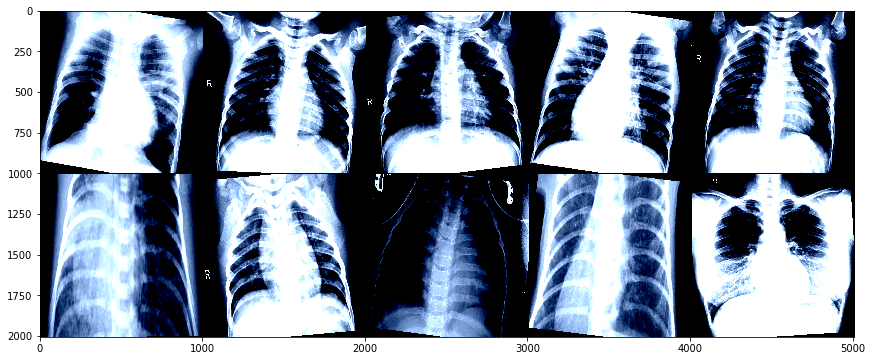

In [50]:
im = make_grid(images, nrow=5)

plt.figure(figsize=(15, 6))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))

In [51]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 12, 5, 1)
        self.conv2 = nn.Conv2d(12, 24, 5, 1)
        self.conv3 = nn.Conv2d(24, 30, 5, 1) # 1000-4/2 - 4 / 2 - 4 / 2
        self.conv4 = nn.Conv2d(30, 36, 5, 1)
        self.fc1 = nn.Linear(58*58*36, 256)
        self.fc2 = nn.Linear(256, 144)
        self.fc3 = nn.Linear(144, 84)
        self.fc4 = nn.Linear(84, 16)
        self.fc5 = nn.Linear(16, 2)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2, 2)
        
        x = x.view(-1, 58*58*36)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        
        return F.log_softmax(x, dim=1)

In [52]:
model = CNN().cuda()

In [53]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [54]:
model

CNN(
  (conv1): Conv2d(3, 12, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(12, 24, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(24, 30, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(30, 36, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=121104, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=144, bias=True)
  (fc3): Linear(in_features=144, out_features=84, bias=True)
  (fc4): Linear(in_features=84, out_features=16, bias=True)
  (fc5): Linear(in_features=16, out_features=2, bias=True)
)

In [55]:
params = 0

for p in model.parameters():
    print(p.numel())
    params += p.numel()

print(params)

900
12
7200
24
18000
30
27000
36
31002624
256
36864
144
12096
84
1344
16
32
2
31106664
